# Biomodels Curation

In [1]:
import importlib

import jax

jax.config.update("jax_platform_name", "cpu")

from tempfile import NamedTemporaryFile
from urllib.request import urlopen

import matplotlib.pyplot as plt
from sbmltoodejax.modulegeneration import GenerateModel
from sbmltoodejax.parse import ParseSBMLFile

## Utils 

In [2]:
def generate_model(
    model_idx,
    deltaT=0.1,
    atol=1e-6,
    rtol=1e-12,
    vmap_over_reactions=False,
):

    model_jax_file = "jax_model.py"
    model_url = f"https://www.ebi.ac.uk/biomodels/model/download/BIOMD{model_idx:010d}.2?filename=BIOMD{model_idx:010d}_url.xml"
    with urlopen(model_url) as response:
        model_xml_body = response.read().decode("utf-8")
    model_data = ParseSBMLFile(model_xml_body)
    GenerateModel(
        model_data,
        model_jax_file,
        deltaT=deltaT,
        atol=atol,
        rtol=rtol,
        vmap_over_reactions=vmap_over_reactions,
    )
    return model_jax_file


def load_model(
    model_idx,
    deltaT=0.1,
    atol=1e-6,
    rtol=1e-12,
    vmap_over_reactions=False,
):
    model_jax_filepath = generate_model(
        model_idx,
        deltaT=deltaT,
        atol=atol,
        rtol=rtol,
        vmap_over_reactions=vmap_over_reactions,
    )
    spec = importlib.util.spec_from_file_location("JaxModelSpec", model_jax_filepath)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    model_cls = getattr(module, "ModelRollout")

    return model_cls()

## Correct simulation of models from the BioModels website

### Goldbeter1991 - Min Mit Oscil

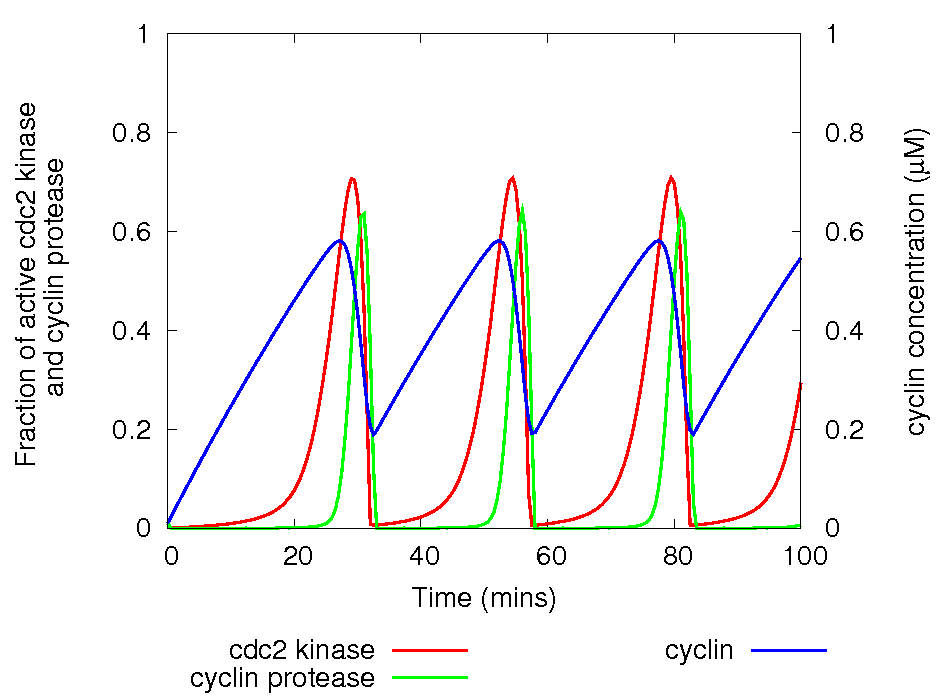

Taken from https://www.ebi.ac.uk/biomodels/BIOMD0000000003#Curation

In [3]:
model = load_model(3)
n_secs = 100
ys, ws, times = model(int(n_secs / model.deltaT))

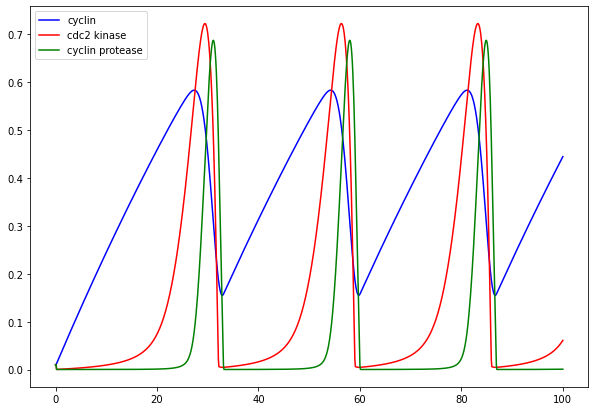

In [4]:
plt.figure(figsize=(10, 7))
plt.plot(times, ys[model.modelstepfunc.y_indexes["C"]], color="blue", label="cyclin")
plt.plot(
    times, ys[model.modelstepfunc.y_indexes["M"]], color="red", label="cdc2 kinase"
)
plt.plot(
    times,
    ys[model.modelstepfunc.y_indexes["X"]],
    color="green",
    label="cyclin protease",
)
plt.legend()
plt.show()

### Hornberg2005_ERKcascade

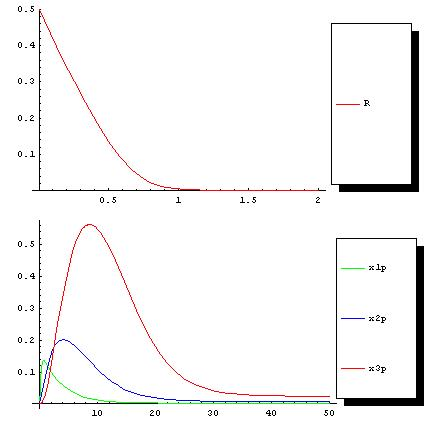

From https://www.ebi.ac.uk/biomodels/BIOMD0000000084#Curation

In [5]:
model = load_model(84)
n_secs = 50
ys, ws, times = model(int(n_secs / model.deltaT))

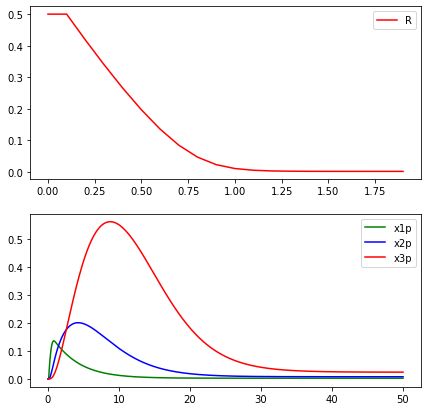

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(7, 7))
ax[0].plot(
    times[: int(2 / model.deltaT)],
    ys[model.modelstepfunc.y_indexes["R"], : int(2 / model.deltaT)],
    color="red",
    label="R",
)
ax[0].legend()

ax[1].plot(times, ys[model.modelstepfunc.y_indexes["x1p"]], color="green", label="x1p")
ax[1].plot(times, ys[model.modelstepfunc.y_indexes["x2p"]], color="blue", label="x2p")
ax[1].plot(times, ys[model.modelstepfunc.y_indexes["x3p"]], color="red", label="x3p")
ax[1].legend()
plt.show()

## Models with events (not handled at the moment)

### Novak1997 - Cell Cycle 

/!\ SBMLtoODEJax not handling events

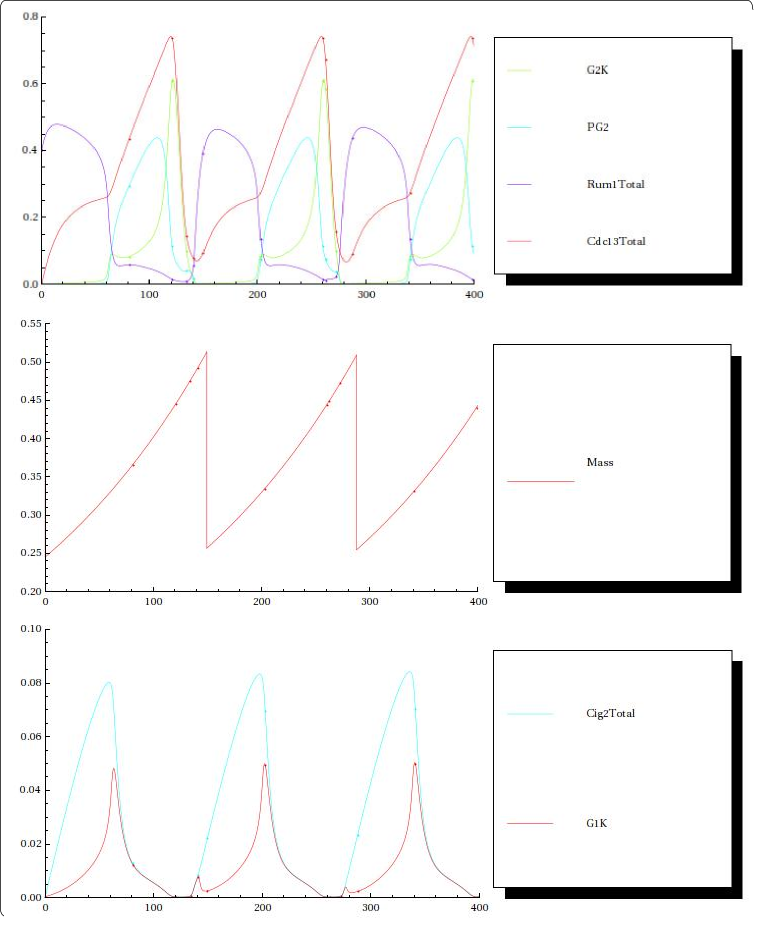

Taken from https://www.ebi.ac.uk/biomodels/BIOMD0000000007#Curation

In [7]:
model = load_model(7)
n_secs = 400
ys, ws, times = model(int(n_secs / model.deltaT))

NotImplementedError: Events not Handled

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(7, 10))
ax[0].plot(times, ys[model.modelstepfunc.y_indexes["G2K"]], color="green", label="G2K")
ax[0].plot(times, ys[model.modelstepfunc.y_indexes["PG2"]], color="blue", label="PG2")
ax[0].plot(
    times,
    ws[model.modelstepfunc.w_indexes["Rum1Total"]],
    color="purple",
    label="Rum1Total",
)
ax[0].plot(
    times,
    ws[model.modelstepfunc.w_indexes["Cdc13Total"]],
    color="pink",
    label="Cdc13Total",
)
ax[0].legend()

ax[1].plot(times, ys[model.modelstepfunc.y_indexes["Mass"]], color="red", label="Mass")
ax[1].legend()

ax[2].plot(
    times,
    ws[model.modelstepfunc.w_indexes["Cig2Total"]],
    color="blue",
    label="Cig2Total",
)
ax[2].plot(times, ys[model.modelstepfunc.y_indexes["G1K"]], color="red", label="G1K")
ax[2].legend()
plt.show()

### Edelstein1996 - EPSP ACh event

/!\ Model 1 and 2 Not Working - seems to be the solver but I have to check

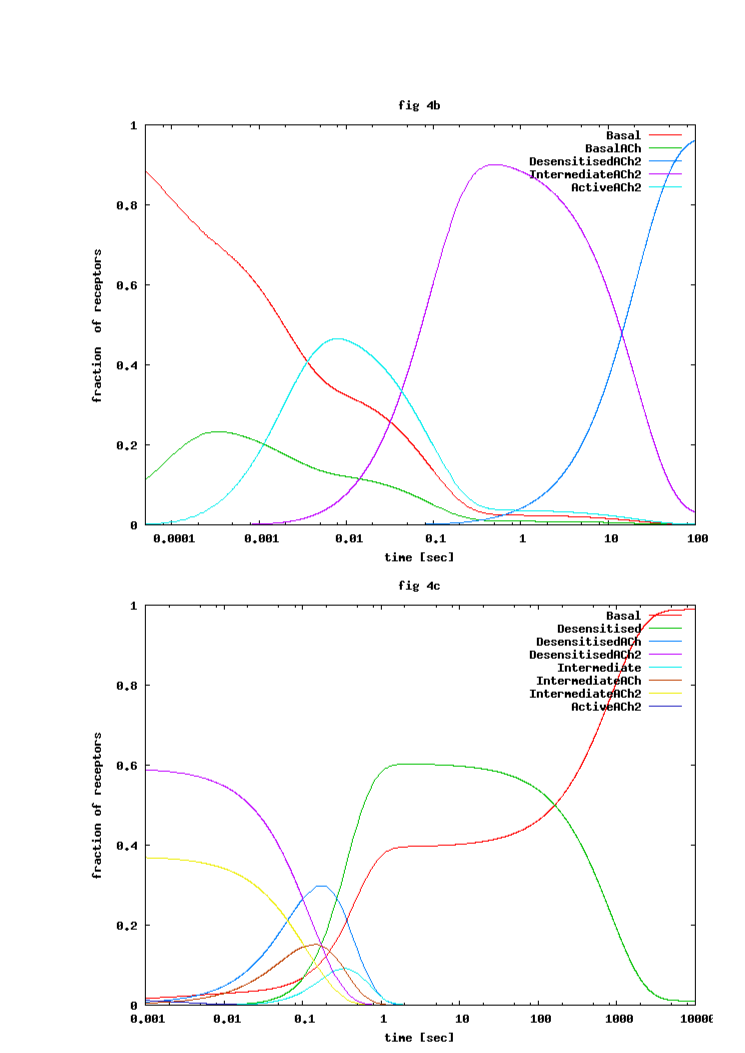

Taken from https://www.ebi.ac.uk/biomodels/BIOMD0000000001#Curation 

In [ ]:
model = load_model(1, deltaT=0.01, atol=1e-6, rtol=1e-12)
n_secs = 100
ys, ws, times = model(int(n_secs / model.deltaT))

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(7, 10))
ax[0].plot(times, ys[model.modelstepfunc.y_indexes["B"]], color="red", label="B")
ax[0].plot(times, ys[model.modelstepfunc.y_indexes["BL"]], color="green", label="BL")
ax[0].plot(times, ys[model.modelstepfunc.y_indexes["D"]], color="blue", label="D")
ax[0].plot(times, ys[model.modelstepfunc.y_indexes["I"]], color="purple", label="I")
ax[0].plot(times, ys[model.modelstepfunc.y_indexes["A"]], color="turquoise", label="A")
ax[0].legend()

ax[1].plot(times, ys[model.modelstepfunc.y_indexes["B"]], color="red", label="B")
ax[1].plot(times, ys[model.modelstepfunc.y_indexes["D"]], color="green", label="D")
ax[1].plot(times, ys[model.modelstepfunc.y_indexes["DL"]], color="blue", label="DL")
ax[1].plot(times, ys[model.modelstepfunc.y_indexes["DLL"]], color="purple", label="DLL")
ax[1].plot(times, ys[model.modelstepfunc.y_indexes["I"]], color="turquoise", label="I")
ax[1].plot(times, ys[model.modelstepfunc.y_indexes["IL"]], color="orange", label="IL")
ax[1].plot(times, ys[model.modelstepfunc.y_indexes["ILL"]], color="yellow", label="ILL")
ax[1].plot(times, ys[model.modelstepfunc.y_indexes["A"]], color="blue", label="A")
ax[1].legend()

plt.show()

## Models which return NaN values

### Tyson1991 - Cell Cycle 6 var

/!\ Nan Values

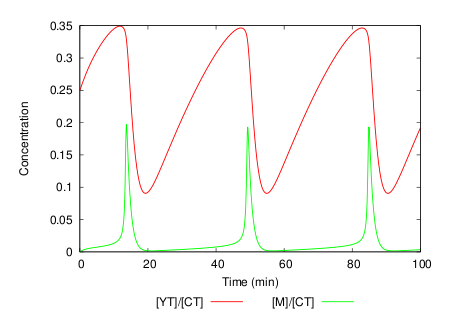


Taken from https://www.ebi.ac.uk/biomodels/BIOMD0000000005#Curation

In [ ]:
model = load_model(5, deltaT=0.01)
n_secs = 100
ys, ws, times = model(int(n_secs / model.deltaT))

In [ ]:
plt.figure(figsize=(10, 7))
print(ys[:, -1])
plt.plot(times, ys[model.modelstepfunc.y_indexes["M"]], color="green", label="[M]/[CT]")
plt.plot(
    times, ys[model.modelstepfunc.y_indexes["YP"]], color="red", label="cdc2 kinase"
)
plt.legend()
plt.show()